In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from model.feature_extractor import DenseNetFE
from model.transformer import Transformer
from model.attention import MultiHeadAttention

In [3]:
from data import get_data_loader, get_vocab, SOS_CHAR, EOS_CHAR, PAD_CHAR
from torchvision import transforms
from utils import ScaleImageByHeight
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import ImageGrid
import skimage
import math

In [5]:
device = 'cuda'
CKPT = 'runs/25-02-2020_15-40-54_tf_vnondb_exp_3_new_attn_fix_linear/weights/BEST_weights.pt'

print('Device = {}'.format(device))
print('Load weight from {}'.format(CKPT))
checkpoint = torch.load(CKPT, map_location=device)
config = checkpoint['config']

cnn = DenseNetFE(config['densenet']['depth'],
                 config['densenet']['n_blocks'],
                 config['densenet']['growth_rate'])

vocab = get_vocab(config['common']['dataset'])
model = Transformer(cnn, vocab.vocab_size, config['tf'])
model = nn.DataParallel(model)
model.to(device)

model.load_state_dict(checkpoint['model'])
# for name, module in model.named_modules():
#     if isinstance(module, MultiHeadAttention):
#         named_modules[name] = module
#         module.register_forward_hook(hook_fn)

test_transform = transforms.Compose([
    transforms.Grayscale(3),
    ScaleImageByHeight(config['common']['scale_height']),
    transforms.ToTensor(),
])

test_loader = get_data_loader(config['common']['dataset'], 'test', 1,
                              test_transform, vocab)

Device = cuda
Load weight from runs/25-02-2020_15-40-54_tf_vnondb_exp_3_new_attn_fix_linear/weights/BEST_weights.pt


In [6]:
iter_test_loader = iter(test_loader)

In [8]:
model.eval()
with torch.no_grad():
    imgs, targets, targets_onehot, lengths = next(iter_test_loader)
    imgs = imgs.to(device)
    targets = targets.to(device)
    targets_onehot = targets_onehot.to(device)

    outputs, weights = model.module.greedy(imgs, targets_onehot[[0]].transpose(0,1), output_weights=True)
    outputs = outputs.topk(1, -1)[1]
    outputs, targets = outputs.squeeze(-1), targets[1:].transpose(0,1).squeeze(-1)
    outputs = outputs.cpu()
    targets = targets.cpu()

['g', 'i', 'à', '<end>']/['g', 'i', 'à', '<end>']


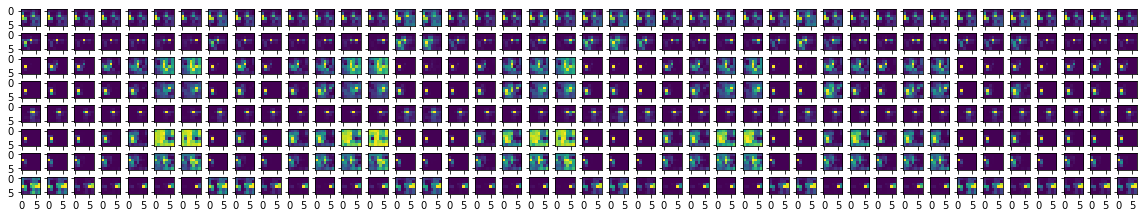

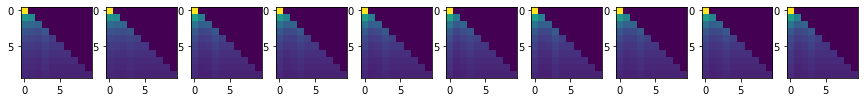

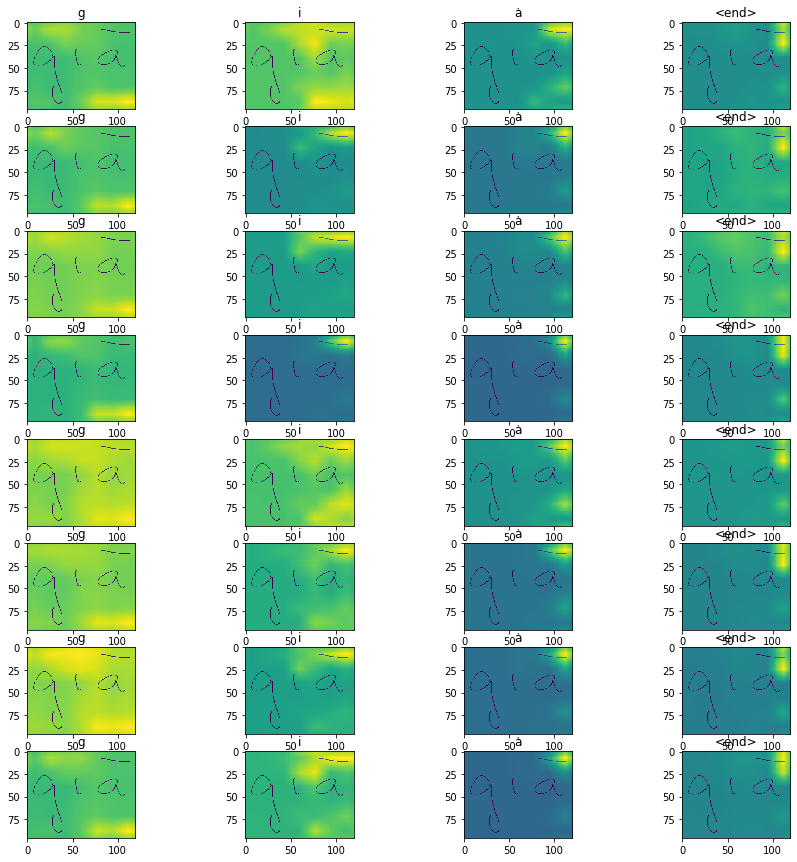

In [35]:
def plot_attention(imgs, predicted, groundtruth, weights):
    imgs = imgs.cpu().squeeze(0) # remove batch_size dim
    imgs = imgs.permute(1,2,0).numpy() # [C,H,W] -> [H,W,C]
    image_rows, image_cols = imgs.shape[:2]
    image_rows, image_cols = round(image_rows/16), round(image_cols/16) # 16 is factor of DenseNet

    image_rows = 6
    image_cols = 7
    
    def plot_attention_text(weights):
        _, decoder_weight = weights
        text_weight, _ = decoder_weight[0] # layer 0
        weight = text_weight.squeeze(1).cpu()
        n_head, text_len = weight.shape[0], len(predicted)
        fig, axeses = plt.subplots(1, n_head, figsize=(15,15), squeeze=False)

        for head in range(n_head):
            text_image_w = weight[head]
            blend = text_image_w
            axeses[0, head].imshow(blend)

    def plot_attention_text_image(imgs, predicted, groundtruth, weights):
        _, decoder_weight = weights
        decoder_weight = decoder_weight[0] # layer 0

        predicted = predicted.squeeze(0) # remove batch_size dim
        groundtruth = groundtruth.squeeze(0) # remove batch_size dim

        predicted = [vocab.int2char[val] for val in predicted.tolist()]
        predicted = predicted[:predicted.index(EOS_CHAR) + 1]

        groundtruth = [vocab.int2char[val] for val in groundtruth.tolist()]
        groundtruth = groundtruth[:groundtruth.index(EOS_CHAR) + 1]

        print('{}/{}'.format(predicted, groundtruth))
        
        text_weight, text_image_weight = decoder_weight
        text_weight = text_weight.cpu() # remove batch_size dim
        text_image_weight = text_image_weight.cpu() # remove batch_size dim

        text_image_weight = text_image_weight.squeeze(1) # remove batch_size
        n_head, text_len = text_image_weight.shape[0], len(predicted)
        text_image_weight = text_image_weight.reshape(n_head, -1, image_rows, image_cols)

        fig, axeses = plt.subplots(n_head, text_len, figsize=(15,15), squeeze=False)
        for head in range(n_head):
            for step in range(text_len):
                axeses[head, step].set_title(predicted[step])
                text_image_w = text_image_weight[head, step]
                text_image_w = skimage.transform.resize(text_image_w, imgs.shape[:2])
                
                alpha = 0.2
                blend = imgs[:,:,0] * alpha + text_image_w * (1-alpha)
#                 blend = text_image_w
                axeses[head, step].imshow(blend)

    def plot_attention_image(imgs, weights):
        encoder_weight, _ = weights
        encoder_weight = encoder_weight[0] # layer 0
        encoder_weight = encoder_weight.squeeze(1).cpu().numpy() # remove batch_size dim
        nhead, T, S = encoder_weight.shape
    
        fig = plt.figure(figsize=(20., 20.))
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                         nrows_ncols=(nhead, T),  # creates 2x2 grid of axes
                         axes_pad=0.1,  # pad between axes in inch.
                         )
        for ax, im in zip(grid, encoder_weight.reshape(-1, image_rows, image_cols)):
            ax.imshow(im)


    plot_attention_image(imgs, weights)
    plot_attention_text(weights)
    plot_attention_text_image(imgs, predicted, groundtruth, weights)

plot_attention(imgs, outputs, targets, weights)